In [1]:
import numpy as np
import sys,os
os.environ["JAX_PLATFORMS"] = "cpu"
from time import time
import matplotlib.pyplot as plt
sys.path.append('../../')
from paths import *
from LLM.LLM_paths import *
from dadapy.hamming import *
start = time()

#for fancy plotting
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 18
plt.rcParams.update({'figure.autolayout': True})
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['ggplot']['axes.prop_cycle'].by_key()['color']
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
# print(plt.rcParams.keys())
np.set_printoptions(precision=3)
# markers = ['p','p','o','o','x','x']
markers = ['s']

/leonardo/home/userexternal/sacevedo/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sub_lengths = np.arange(120,300+1,20,dtype=int)

layer_ids = [0,24]
emb_dim = 1024
Nbits = 1


normalize = 1
normalization = 1.
batch_randomize_flags = [0,1]

ID_BID = np.zeros(shape=(len(layer_ids),
                         len(sub_lengths),
                         len(batch_randomize_flags))
)
ID_FCI = np.zeros(shape=(len(layer_ids),
                         len(sub_lengths),
                         len(batch_randomize_flags))
)
ID_GRIDE = np.zeros(shape=(len(layer_ids),
                         len(sub_lengths),
                         len(batch_randomize_flags))
)

alphamax = .7
alphamin = 1E-5
seed = 111
delta = 7E-4
Nsteps = int(5E6)

Nbits = 1
randomize = 0
Ntokens = 0
Lconcat = 150
corpus = 'Wikitext'
LLM = 'Pythia'

FCI = True
GRIDE = True
batch_size = 100

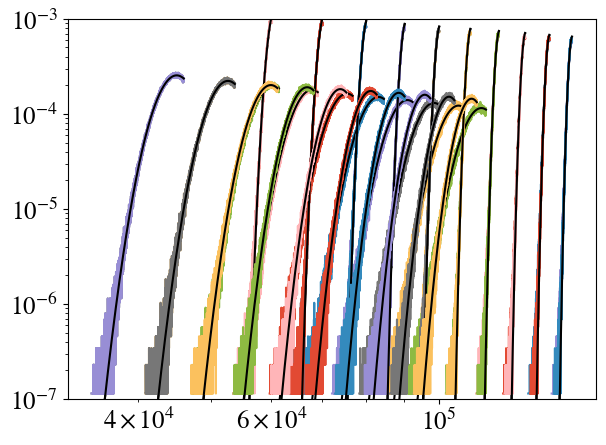

In [28]:
fig = plt.figure()
ax = fig.add_subplot()

for batch_r_id,batch_randomize in enumerate(batch_randomize_flags):
  optfolder0 = make_optfolder0(corpus,LLM,randomize,Ntokens,Lconcat,batch_randomize,Nbits)
  for layer_index,layer_id in enumerate(layer_ids):
    for sub_length_id,sub_length in enumerate(sub_lengths):
      B = BID(
              alphamin=alphamin,
              alphamax=alphamax,
              seed=seed,
              delta=delta,
              Nsteps=Nsteps,
              optfolder0=optfolder0+f'sublength{sub_length}/layer_id{layer_id}/',
              )
      remp,Pemp,Pmodel = B.load_fit()    # to do explicit model validation
      (r_max,
      ID_BID[layer_index,sub_length_id,batch_r_id],
      d1,    # the second variational parameter
      logKL_list, # logarithm of the KL divergence after optimization
      ) = B.load_results()

      if FCI:
        N_batches = 20
        resultsfolder = makefolder(base=f'FCI/results/FCI/',
                      #  precision=2,
                      Nbits=1,
                      batch_randomize=batch_randomize,
                      Ns=N_batches*batch_size,
                      layer_id=layer_id,
                      sub_length=sub_length,
                      )
        d,x0,err = np.loadtxt(resultsfolder + 'FCI_fit.txt',unpack=True)
        ID_FCI[layer_index,sub_length_id,batch_r_id] = d 
      if GRIDE:
        N_batches = 50
        resultsfolder = makefolder(base=f'GRIDE/results/',
                        create_folder=False,
                        #  precision=2,
                        batch_randomize=batch_randomize,
                        Ns=N_batches*batch_size,
                        layer_id=layer_id,
                        sub_length=sub_length,
                        )
      filename='gride.txt'
      (ids_gride,ids_err_gride,rs_gride) = np.loadtxt(resultsfolder+filename,unpack=True)
      selected_scale_id = 1
      ID_GRIDE[layer_index,sub_length_id,batch_r_id] = ids_gride[selected_scale_id]
      
      
      ax.plot(remp,Pemp)
      ax.plot(remp,Pmodel,color='black')
      ax.set_yscale('log')
      ax.set_xscale('log')
      ax.set_ylim(1E-7,1E-3)



ID_FCI[np.where(ID_FCI > 20000)] = None # code crashes....
if normalize:
  for batch_r_id,batch_randomize in enumerate(batch_randomize_flags):
    for layer_index,layer_id in enumerate(layer_ids):
      for sub_length_id,sub_length in enumerate(sub_lengths):
        normalization = sub_length*emb_dim 
        ID_FCI[layer_index,sub_length_id,batch_r_id] /= normalization
        ID_BID[layer_index,sub_length_id,batch_r_id] /= normalization
        ID_GRIDE[layer_index,sub_length_id,batch_r_id] /= normalization

if False:
  for batch_r_id,batch_randomize in enumerate(batch_randomize_flags):
    for layer_index,layer_id in enumerate(layer_ids):
      ID_FCI[layer_index,:,batch_r_id] /=  ID_FCI[layer_index,0,batch_r_id]
      ID_BID[layer_index,:,batch_r_id] /=  ID_BID[layer_index,0,batch_r_id]
      ID_GRIDE[layer_index,:,batch_r_id] /= ID_GRIDE[layer_index,0,batch_r_id]

layer_id=24
p=array([-0.427, -1.066])
cov=array([[ 7.521e-06, -3.991e-05],
       [-3.991e-05,  2.124e-04]])


[]

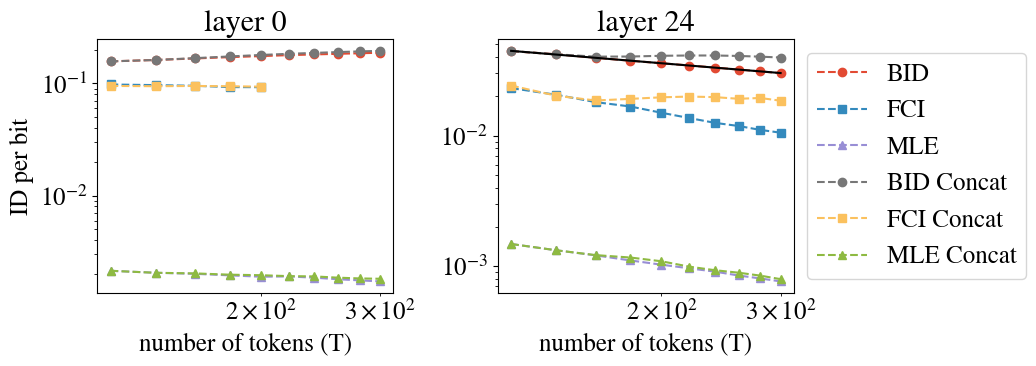

In [29]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

for layer_index,layer_id in enumerate(layer_ids):
  for batch_r_id,batch_randomize in enumerate(batch_randomize_flags):
    lbl_BID = f"BID"
    lbl_GRIDE = f"MLE"
    lbl_FCI = f"FCI"
    if batch_randomize:
      lbl_BID += ' Concat'
      lbl_GRIDE += ' Concat'
      lbl_FCI += ' Concat'
    ax[layer_index].plot(sub_lengths,
            ID_BID[layer_index,:,batch_r_id], 
            label=lbl_BID,
            linestyle='dashed',
            marker='o',
            )
    ax[layer_index].plot(sub_lengths,
            ID_FCI[layer_index,:,batch_r_id],
            label=lbl_FCI,
            linestyle='dashed',
            marker='s',
            )
    ax[layer_index].plot(sub_lengths,
          ID_GRIDE[layer_index,:,batch_r_id],
          label=lbl_GRIDE,
          linestyle='dashed',
          marker='^',
          )
    if batch_r_id == 0 and layer_index == 1:
      print(f'{layer_id=}')
      p,cov = np.polyfit(np.log(sub_lengths),np.log(ID_BID[layer_index,:,0]),deg=1,cov=True)
      print(f'{p=}')
      print(f'{cov=}')
      ax[layer_index].plot(sub_lengths,np.exp(p[1])*sub_lengths**p[0],color='black',zorder=5)
  ax[layer_index].set_yscale('log')
  ax[layer_index].set_xscale('log')
  ax[layer_index].set_xlabel('number of tokens (T)')
  ax[layer_index].set_title(f"layer {layer_id}")


  # # ax.legend(loc='upper left')


  # ax[layer_index].vlines(150,
  #           ax[layer_index].get_ylim()[0],
  #           ax[layer_index].get_ylim()[1],
  #           linestyles='dashed',
  #           color='gray')
  # ax[layer_index].set_xlim(np.nanmin(sub_lengths)*.9,
  #             np.nanmax(sub_lengths)*1.1)
# ax.set_ylim(np.nanmin(ID_FCI)*.9,
#             np.nanmax(ID_FCI)*1.1)

if normalize:
  ylabel = 'ID per bit'
else:
  ylabel = 'ID'
ax[0].set_ylabel(ylabel)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.plot(bbox_hinches=True)

In [10]:
fig.savefig(f'results/comparison.pdf',bbox_inches='tight')

In [6]:
np.printoptions(precision=5)
layer_index = 1
p,cov = np.polyfit(np.log(sub_lengths),np.log(ID_GRIDE[layer_index,:,0]),deg=1,cov=True)
print(f'{p=}')
print(f'{cov=}')
p,cov = np.polyfit(np.log(sub_lengths),np.log(ID_BID[layer_index,:,0]),deg=1,cov=True)
print(f'{p=}')
print(f'{cov=}')
p,cov = np.polyfit(np.log(sub_lengths)[:],np.log(ID_FCI[layer_index,:,0]),deg=1,cov=True)
print(f'{p=}')
print(f'{cov=}')

p=array([  7.57 , -36.511])
cov=array([[ 14.268, -74.81 ],
       [-74.81 , 393.905]])
p=array([  9.524, -43.525])
cov=array([[  20.573, -107.867],
       [-107.867,  567.963]])
p=array([  8.793, -40.496])
cov=array([[  19.429, -101.871],
       [-101.871,  536.391]])


# Comparing slopes

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

for layer_index,layer_id in enumerate(layer_ids):
  for batch_r_id,batch_randomize in enumerate(batch_randomize_flags):
    lbl_BID = f"BID"
    lbl_GRIDE = f"MLE"
    lbl_FCI = f"FCI"
    if batch_randomize:
      lbl_BID += ' Concat'
      lbl_GRIDE += ' Concat'
      lbl_FCI += ' Concat'
    ax[layer_index].plot(sub_lengths,
            ID_BID[layer_index,:,batch_r_id], 
            label=lbl_BID,
            linestyle='dashed',
            marker='o',
            )
    ax[layer_index].plot(sub_lengths,
            ID_FCI[layer_index,:,batch_r_id],
            label=lbl_FCI,
            linestyle='dashed',
            marker='s',
            )
    ax[layer_index].plot(sub_lengths,
          ID_GRIDE[layer_index,:,batch_r_id],
          label=lbl_GRIDE,
          linestyle='dashed',
          marker='^',
          )
    if batch_r_id == 0 and layer_index == 1:
      print(f'{layer_id=}')
      p,cov = np.polyfit(np.log(sub_lengths),np.log(ID_BID[layer_index,:,0]),deg=1,cov=True)
      print(f'{p=}')
      print(f'{cov=}')
      ax[layer_index].plot(sub_lengths,np.exp(p[1])*sub_lengths**p[0],color='black',zorder=5)
  ax[layer_index].set_yscale('log')
  ax[layer_index].set_xscale('log')
  ax[layer_index].set_xlabel('number of tokens (T)')
  ax[layer_index].set_title(f"layer {layer_id}")

if normalize:
  ylabel = 'ID per bit'
else:
  ylabel = 'ID'
ax[0].set_ylabel(ylabel)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.plot(bbox_hinches=True)